# Ensemble phase picking (window data, full band)
- Yiyu Ni (niyiyu@uw.edu)
- Last updated: May 1, 2023

## 0) import necessary packages

In [1]:
import gc
import h5py
import obspy
import torch
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append("../../ELEP/src/")

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
pd.set_option('display.max_columns', None)

from ensemble_coherence import ensemble_semblance
from ensemble_statistics import ensemble_statistics
from trigger_func import picks_summary_simple
import seisbench.models as sbm
from obspy.signal.filter import bandpass
from meta_learners import ensemble_regressor_cnn as ensemble_learners

## 1) Load and pre-processing PNW waveform data

In [8]:
f_waveform = h5py.File("./data/waveforms.hdf5", 'r') 

# load waveforms (ENZ order)
waveform = f_waveform['/data/bucket1'][:, :, :].astype(np.float32)

metadata = pd.read_csv("./data/metadata.csv")

nwin, ncha, twin = waveform.shape
print(waveform.shape)
# nw: window sample 
# nc: channel
# twin: time window sample

(100, 3, 6000)


In [22]:
## switch to ZNE order for EqTransformer
waveform = waveform[:, ::-1, :].copy()

## demean
waveform -= np.mean(waveform, axis=-1, keepdims=True)

# taper the waveform
tap = 0.5 * (1 + np.cos(np.linspace(np.pi, 2 * np.pi, 6)))
waveform[:, :, :6] *= tap
waveform[:, :, -6:] *= tap[::-1]

for iwin in range(nwin):
    waveform[iwin, :, :] = bandpass(waveform[iwin, :, :], 1, 45, 100, 
                                 corners = 4, zerophase=True)

windows_std = waveform.copy()
windows_max = waveform.copy()

# normalization
for iwin in range(nwin):
    windows_std[iwin, :, :] /= (np.std(windows_std[iwin, :, :]) + 1e-10)
    windows_max[iwin, :] = windows_max[iwin, :] / (np.max(np.abs(windows_max[iwin, :]), 
                                                         axis=-1, keepdims=True) + 1e-10)
print(f"shape of prediciton input is {windows_max.shape}")

shape of prediciton input is (100, 3, 6000)


## plot waveforms

(-311.32891845703125, 200.97567749023438)

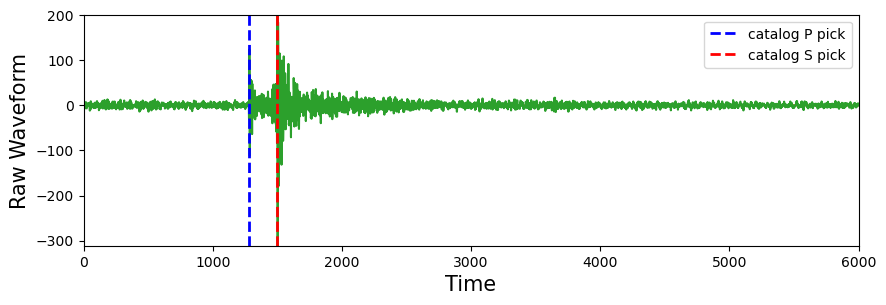

In [23]:
iwin = np.random.randint(100)
d = waveform[iwin, :, :]
plt.figure(figsize = (10, 3))
plt.plot(d.T)
plt.vlines(metadata.loc[iwin, 'trace_P_arrival_sample'], d.max(), d.min(), 
           color = 'b', label = "catalog P pick", linewidth = 2, linestyle = '--')
plt.vlines(metadata.loc[iwin, 'trace_S_arrival_sample'], d.max(), d.min(), 
           color = 'r', label = "catalog S pick", linewidth = 2, linestyle = '--')
plt.legend(loc = 'upper right')
plt.xlabel("Time", fontsize = 15)
plt.ylabel("Raw Waveform", fontsize = 15)
plt.xlim([0, 6000]); 
plt.ylim([d.min(), d.max()])

## 2) EqT batch picking using 6 pre-trained model

Mousavi, S.M., Ellsworth, W.L., Zhu, W., Chuang, L, Y., and Beroza, G, C. Earthquake transformer—an attentive deep-learning model for simultaneous earthquake detection and phase picking. Nat Commun 11, 3952 (2020). https://doi.org/10.1038/s41467-020-17591-w

In [24]:
pretrain_list = ['original', 'ethz', 'instance', 'scedc', 'stead', 'neic']

# dim 0: 0 = P, 1 = S
batch_pred = np.zeros([2, len(pretrain_list), nwin, twin], dtype = np.float32)

for ipre, pretrain in enumerate(pretrain_list):
    
    t0 = time.time()
    eqt = sbm.EQTransformer.from_pretrained(pretrain)
    eqt.to(torch.device("cuda"));

    # time window prediction
    eqt._annotate_args['blinding'] = ('Number of prediction samples to discard on \
                                     each side of each window prediction', (0, 0))

    # very important for torch model
    eqt.eval();
    
    if pretrain == 'original':
        # batch prediction through torch model
        windows_std_tt = torch.Tensor(windows_std)
        _torch_pred = eqt(windows_std_tt.to(torch.device("cuda")))
    else:
        windows_max_tt = torch.Tensor(windows_max)
        _torch_pred = eqt(windows_max_tt.to(torch.device("cuda")))
        
    # omit the detection branch and only save P- and S-wave picking branch
    batch_pred[0, ipre, :] = _torch_pred[1].detach().cpu().numpy()[:, :]
    batch_pred[1, ipre, :] = _torch_pred[2].detach().cpu().numpy()[:, :]
    
    t1 = time.time()
    print(f"picking using [{pretrain}] model: %.3f second" % (t1 - t0))

# clean up memory
del _torch_pred, windows_max_tt, windows_std_tt, eqt
del windows_std, windows_max
gc.collect()
torch.cuda.empty_cache()
print(f"result shape is {batch_pred.shape}")

picking using [original] model: 0.128 second
picking using [ethz] model: 0.049 second
picking using [instance] model: 0.038 second
picking using [scedc] model: 0.037 second
picking using [stead] model: 0.038 second
picking using [neic] model: 0.037 second
result shape is (2, 6, 100, 6000)


Text(0.5, 0, 'Time')

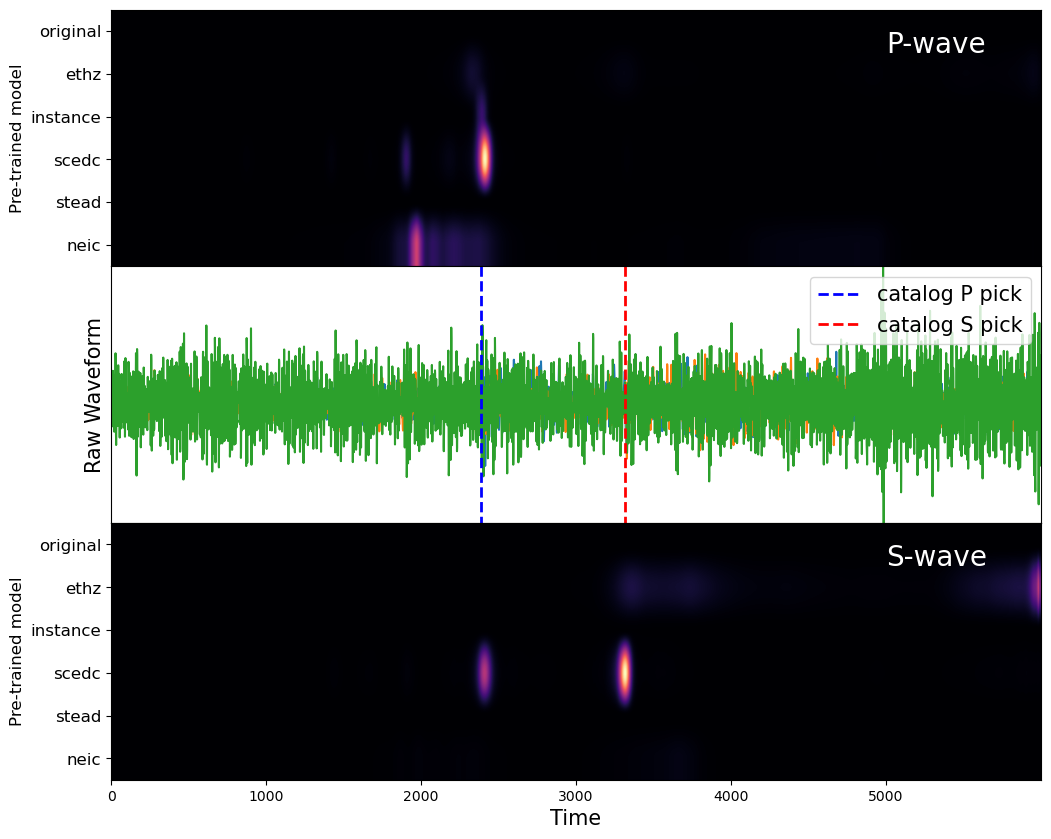

In [27]:
# for plotting only. choose a random index
iwin = np.random.randint(100)

plt.figure(figsize = (12, 10))
plt.subplots_adjust(hspace = 0.)
plt.subplot(3, 1, 1)
plt.ylabel("Pre-trained model", fontsize = 12)
plt.text(5000, 0.5, "P-wave", color = 'white', fontsize = 20)
plt.imshow(batch_pred[0, :, iwin, :], aspect = 'auto', cmap = 'magma')
_ = plt.yticks(np.arange(6), pretrain_list, fontsize = 12)
plt.xticks([]); 

plt.subplot(3, 1, 2)
d = waveform[iwin, :, :]
plt.plot(d.T)
plt.xlim([0, 6000]); plt.ylim([d.min(), d.max()])
plt.xticks([]); plt.yticks([])
plt.vlines(metadata.loc[iwin, 'trace_P_arrival_sample'], d.max(), d.min(), 
           color = 'b', label = "catalog P pick", linewidth = 2, linestyle = '--')
plt.vlines(metadata.loc[iwin, 'trace_S_arrival_sample'], d.max(), d.min(), 
           color = 'r', label = "catalog S pick", linewidth = 2, linestyle = '--')
plt.ylabel("Raw Waveform", fontsize = 15)
plt.legend(loc = 'upper right', fontsize = 15)

plt.subplot(3, 1, 3)
plt.text(5000, 0.5, "S-wave", color = 'white', fontsize = 20)
plt.ylabel("Pre-trained model", fontsize = 12)
plt.imshow(batch_pred[1, :, iwin, :], aspect = 'auto', cmap = 'magma')
_ = plt.yticks(np.arange(6), pretrain_list, fontsize = 12)
plt.xlabel("Time", fontsize = 15)

## ensemble calculation

In [7]:
paras_simple = {'dt':0.01, 'win':1, 'window_flag':False, 'method':'max'}
paras_semblance = {'dt':0.01, 'semblance_order':2, 'window_flag':True, 
                   'semblance_win':0.5, 'weight_flag':'max'}
d_thrd, p_thrd, s_thrd = 0.1, 0.1, 0.05

# dim 0: 0 = P, 1 = S
# ensemble maximum
max_pred = np.zeros([2, nwin, twin], dtype = np.float32)

# ensemble semblance
smb_pred = np.zeros([2, nwin, twin], dtype = np.float32)

In [8]:
for iwin in tqdm(range(nwin)):
    # 0 for P-wave
    max_pred[0, iwin, :] = ensemble_statistics(batch_pred[0, :, iwin, :], paras_simple)
    smb_pred[0, iwin, :] = ensemble_semblance(batch_pred[0, :, iwin, :], paras_semblance)
    
    # 1 for P-wave
    max_pred[1, iwin, :] = ensemble_statistics(batch_pred[1, :, iwin, :], paras_simple)
    smb_pred[1, iwin, :] = ensemble_semblance(batch_pred[1, :, iwin, :], paras_semblance)

100%|██████████| 100/100 [00:09<00:00, 11.07it/s]


In [9]:
# time index for peak prediciton (P- and S-wave)
pretrain_peak = np.zeros([2, 100, 6])
max_peak = np.zeros([2, 100])
smb_peak = np.zeros([2, 100])

In [10]:
for ipha, thrd in zip([0, 1], [p_thrd, s_thrd]):
    for iwin in tqdm(range(nwin)):
        for ipre in range(6):
            try:
                # picking with threshold for 6 pretrained models
                pretrain_peak[ipha, iwin, ipre] = picks_summary_simple(batch_pred[ipha, ipre, iwin, :], thrd = thrd)[0]
            except:
                # if no pick, fill NaN
                pretrain_peak[ipha, iwin, ipre] = np.nan

        try:
            # picking with threshold for ensemble maximum
            max_peak[ipha, iwin] = picks_summary_simple(max_pred[ipha, iwin, :], thrd = thrd)[0]
        except:
            # if no pick, fill NaN
            max_peak[ipha, iwin] = np.nan

        try:
            # picking with threshold for ensemble semblance
            smb_peak[ipha, iwin] = picks_summary_simple(smb_pred[ipha, iwin, :], thrd = thrd)[0]
        except:
            # if no pick, fill NaN
            smb_peak[ipha, iwin] = np.nan

100%|██████████| 100/100 [00:00<00:00, 3248.02it/s]


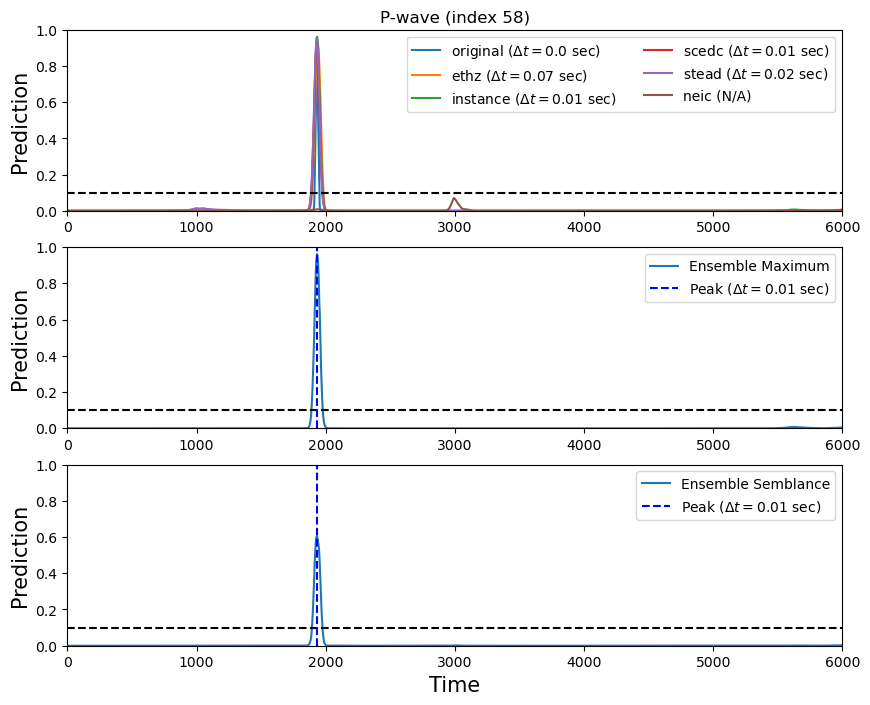

In [11]:
iwin = np.random.randint(100)
cat_p = metadata.loc[iwin, 'trace_P_arrival_sample']
plt.figure(figsize = (10, 8))
plt.subplot(3, 1, 1)
plt.title(f"P-wave (index {iwin})")
for ipre, pretrain in enumerate(pretrain_list):
    if not np.isnan(pretrain_peak[0, iwin, ipre]):
        plt.plot(batch_pred[0, ipre, iwin, :], 
             label = f"{pretrain} ($\\Delta t = ${np.abs(pretrain_peak[0, iwin, ipre] - cat_p)/100} sec)")
    else:
        plt.plot(batch_pred[0, ipre, iwin, :], 
             label = f"{pretrain} (N/A)")
plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, twin]);
plt.hlines(p_thrd, 0, twin, linestyle = '--', color = 'k')
plt.legend(ncols = 2, loc = 'upper right')

plt.subplot(3, 1, 2)
plt.plot(max_pred[0, iwin, :], label = "Ensemble Maximum")
plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, twin]);
plt.hlines(p_thrd, 0, twin, linestyle = '--', color = 'k')
if not np.isnan(max_peak[0, iwin]):
    plt.vlines(max_peak[0, iwin], 0, 1, color = 'b', linestyle = '--', 
               label = f'Peak ($\\Delta t = ${np.abs(max_peak[0, iwin] - cat_p)/100} sec)')
plt.legend(loc = 'upper right')

plt.subplot(3, 1, 3)
plt.plot(smb_pred[0, iwin, :], label = "Ensemble Semblance")
plt.xlabel("Time", fontsize = 15); plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, twin]);
plt.hlines(p_thrd, 0, twin, linestyle = '--', color = 'k')
if not np.isnan(smb_peak[0, iwin]):
    plt.vlines(smb_peak[0, iwin], 0, 1,  color = 'b', linestyle = '--', 
           label = f'Peak ($\\Delta t = ${np.abs(smb_peak[0, iwin] - cat_p)/100} sec)')
plt.legend(loc = 'upper right')

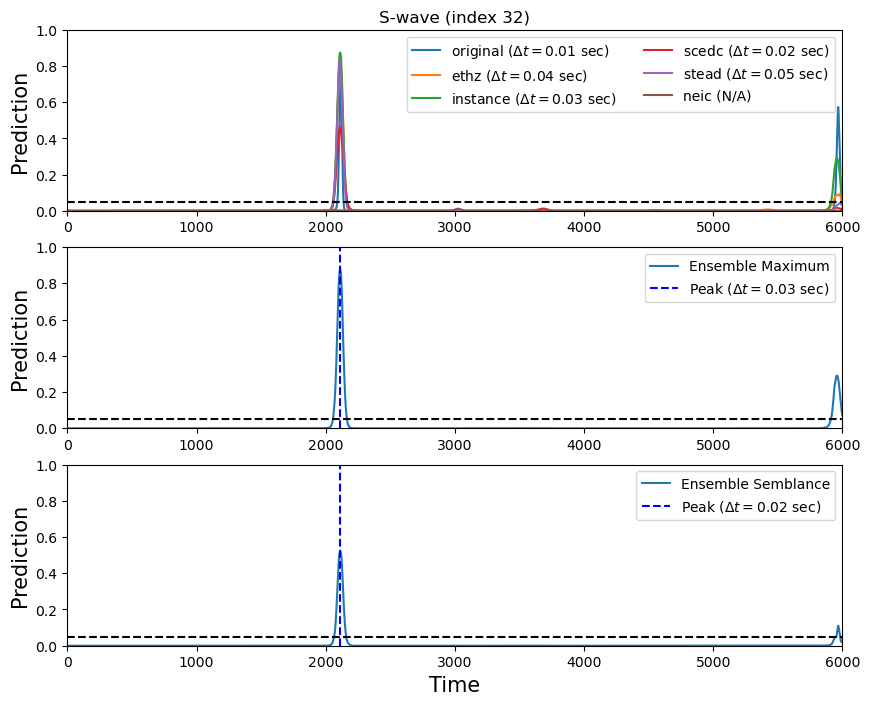

In [12]:
iwin = np.random.randint(100)
cat_s = metadata.loc[iwin, 'trace_S_arrival_sample']
plt.figure(figsize = (10, 8))
plt.subplot(3, 1, 1)
plt.title(f"S-wave (index {iwin})")
for ipre, pretrain in enumerate(pretrain_list):
    if not np.isnan(pretrain_peak[1, iwin, ipre]):
        plt.plot(batch_pred[1, ipre, iwin, :], 
             label = f"{pretrain} ($\\Delta t = ${np.abs(pretrain_peak[1, iwin, ipre] - cat_s)/100} sec)")
    else:
        plt.plot(batch_pred[1, ipre, iwin, :], 
             label = f"{pretrain} (N/A)")
plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, twin]);
plt.hlines(s_thrd, 0, twin, linestyle = '--', color = 'k')
plt.legend(ncols = 2, loc = 'upper right')

plt.subplot(3, 1, 2)
plt.plot(max_pred[1, iwin, :], label = "Ensemble Maximum")
plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, twin]);
plt.hlines(s_thrd, 0, twin, linestyle = '--', color = 'k')
if not np.isnan(max_peak[1, iwin]):
    plt.vlines(max_peak[1, iwin], 0, 1, color = 'b', linestyle = '--', 
               label = f'Peak ($\\Delta t = ${np.abs(max_peak[1, iwin] - cat_s)/100} sec)')
plt.legend(loc = 'upper right')

plt.subplot(3, 1, 3)
plt.plot(smb_pred[1, iwin, :], label = "Ensemble Semblance")
plt.xlabel("Time", fontsize = 15); plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, twin]);
plt.hlines(s_thrd, 0, twin, linestyle = '--', color = 'k')
if not np.isnan(smb_peak[1, iwin]):
    plt.vlines(smb_peak[1, iwin], 0, 1,  color = 'b', linestyle = '--', 
           label = f'Peak ($\\Delta t = ${np.abs(smb_peak[1, iwin] - cat_s)/100} sec)')
plt.legend(loc = 'upper right')

## meta picker

In [18]:
# load pre-trained meta picker
meta_p_picker = torch.load("./data/fullband_P.pt").to("cpu"); meta_p_picker.eval();
meta_s_picker = torch.load("./data/fullband_S.pt").to("cpu"); meta_s_picker.eval();

meta_p_picker

ensemble_regressor_cnn(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(1, 5), stride=(1, 5), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(1, 5), stride=(1, 5), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(1, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(32, 64, kernel_size=(1, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_

In [19]:
idt_p = []; idt_s = []
meta_window_p = np.zeros([nwin, 1, 6, 2000], dtype = np.float32)
meta_window_s = np.zeros([nwin, 1, 6, 2000], dtype = np.float32)

for iwin in range(nwin):
    itp = int(np.nanmin([max_peak[0, iwin], smb_peak[0, iwin]]))
    if itp <= 2000:
        it1 = 0
    elif itp >= 3999:
        it1 = 3999
    else:
        it1 = itp - np.random.randint(100, 900)
    idt_p.append(it1)
    meta_window_p[iwin, 0, :, :] = batch_pred[0, :, iwin, it1:it1+2000]

for iwin in range(nwin):
    its = int(np.nanmax([max_peak[1, iwin], smb_peak[1, iwin]]))
    if its <= 2000:
        it1 = 0
    elif its >= 3999:
        it1 = 3999
    else:
        it1 = its - np.random.randint(100, 900)
    idt_s.append(it1)
    meta_window_s[iwin, 0, :, :] = batch_pred[1, :, iwin, it1:it1+2000]

In [21]:
meta_peak_p = meta_p_picker(torch.Tensor(meta_window_p)).detach().numpy()[:, 0]*2000 + idt_p
meta_peak_s = meta_s_picker(torch.Tensor(meta_window_s)).detach().numpy()[:, 0]*2000 + idt_s

## results

# EOF